In [ ]:
### FFJORD_Implementation.ipynb
# By Cecile Marine BOUCHER, INTRO TO AI class, 2025/10/26
# This code implements FFJORD model based on the paper by Will Grathwohl,
# Ricky T. Q. Chen, Jesse Bettencourt, Ilya Sutskever, David Duvenaud
# (paper link : arXiv:1810.01367)

# Install the required library for ODEs (Ordinary Differential Equations)
!pip install torchdiffeq

# Standard imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import tqdm.notebook as tqdm

from torch.optim.lr_scheduler import ReduceLROnPlateau


# The main tool for this project
from torchdiffeq import odeint_adjoint as odeint

# For reproducibility
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Parameters

# MNIST has 28x28 images
data_dim = 28 * 28
SUBSET_PERCENTAGE = 0.4
BATCH_SIZE = 256

Using device: cuda


In [ ]:
# Transformations for the data

transform = transforms.Compose([
    transforms.ToTensor(),
    # Add uniform noise for dequantization (standard practice for continuous flows)
    transforms.Lambda(lambda x: x + torch.rand_like(x) / 256.),
    transforms.Normalize((0.5,), (0.5,)),
    # Flatten the 28x28 image into a 784-dimensional vector
    transforms.Lambda(lambda x: x.view(-1)),])

# Download the dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# SUBSET SELECTION (40%)
num_samples = len(train_dataset)
subset_size = int(SUBSET_PERCENTAGE * num_samples)
indices = torch.randperm(num_samples)[:subset_size]
train_subset = torch.utils.data.Subset(train_dataset, indices)

print(f"Using {subset_size} samples ({SUBSET_PERCENTAGE*100}%) of the MNIST dataset.")

train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Using 24000 samples (40.0%) of the MNIST dataset.


In [ ]:
#### FFJORD Model Definition

'''
The neural network for the dynamics f(z(t), t)

This network will learn the flow dynamics. It takes as input the current position z(t) and time 't' and returns the "velocity" dz/dt.
This is the core of the model, parameterized by 'θ'.
'''

#### Dynamics Network Code

class DynamicsNet(nn.Module):
    def __init__(self, hidden_dim=256):
        super(DynamicsNet, self).__init__()
        self.net = nn.Sequential(
            # Input dimension is data_dim (784) + 1 (for time t)
            nn.Linear(data_dim + 1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            # Output dimension is data_dim (784)
            nn.Linear(hidden_dim, data_dim)
        )

    def forward(self, t, z):
        # We append time t as an extra dimension to each element of the batch
        if t.dim() == 0: t = t.expand(z.size(0))
        t = t.view(-1, 1)
        # Concatenate the state z and the time t before passing them to the network
        return self.net(torch.cat([z, t], dim=1))

In [ ]:
#### The Hutchinson Estimator

def hutchinson_trace_estimator(dynamics_fn, z, t, n_epsilons=1):
    """
    Estimates the trace of the Jacobian of dynamics_fn with respect to z.
    """

    with torch.enable_grad():
      z.requires_grad_(True)

      trace_estimates = []
      for _ in range(n_epsilons):
          # Sample a noise vector epsilon.
          # The paper mentions a Rademacher or Gaussian distribution.
          # We use Rademacher (values -1 or 1).
          epsilon = torch.randint(low=0, high=2, size=z.shape, device=z.device) * 2 - 1
          epsilon = epsilon.float()

          # Calculate the product f(z, t) * epsilon.
          # This is the first part of the "vector-Jacobian product" (VJP).
          f_val = dynamics_fn(t, z)

          # Calculate the vector-Jacobian product (VJP).
          # This is the autodiff step : we compute (epsilon^T * J).
          # torch.autograd.grad calculates the gradient of (f_val * epsilon).sum() with respect to z.
          vjp_result, = torch.autograd.grad(f_val, z, grad_outputs=epsilon, create_graph=True, retain_graph=True)

          # Calculate the final product (VJP * epsilon) to get the trace estimate.
          trace_estimate = torch.sum(vjp_result * epsilon, dim=1)
          trace_estimates.append(trace_estimate)

      # Average the estimates if n_epsilons > 1.
      final_trace = torch.mean(torch.stack(trace_estimates), dim=0)

    return final_trace

In [ ]:
'''
### FFJORD Model Assembly

We combine the two parts. The model's forward method will solve an ODE that combines the transformation of 'z' and
the calculation of the log-density change.
'''

#### --------------FFJORD MODEL-------------------------

class AugmentedDynamics(nn.Module):
    """
    Defines the augmented derivative vector f_aug(t, z_aug) = [dz/dt, d(log P)/dt, d(Kinetic Reg)/dt].
    This is the function that torchdiffeq will call repeatedly (at each step).
    """
    def __init__(self, dynamics_net, n_epsilons):
        super().__init__()
        self.dynamics_net = dynamics_net
        self.n_epsilons = n_epsilons
        self.data_dim = 784

    def forward(self, t, state):
        # z is the first data_dim components. The state is  [z, log_p, kinetic_reg]
        z = state[:, :self.data_dim]

        # dz/dt = f(z, t)
        dz_dt = self.dynamics_net(t, z)

        # d(log p)/dt = -Tr(∂f/∂z)
        dlogp_dt = -hutchinson_trace_estimator(self.dynamics_net, z, t, self.n_epsilons)

        # d(Kinetic Reg)/dt = 0.5 * ||f(z, t)||^2
        dkinetic_dt = 0.5 * torch.sum(dz_dt ** 2, dim=1)

        # The augmented state derivatives are concatenated in the order: [dz/dt, d(log p)/dt, d(Kinetic Reg)/dt]
        return torch.cat([dz_dt,
                          dlogp_dt.view(-1, 1),
                          dkinetic_dt.view(-1, 1)], dim=1)

class FFJORD(nn.Module):
    def __init__(self, dynamics_net, n_epsilons=1, lambda_reg=0.01):
        super().__init__()
        self.dynamics_net = dynamics_net
        self.n_epsilons = n_epsilons
        self.lambda_reg = lambda_reg
        # We integrate from t=1 to t=0 for inference (used during training and evaluation/loss calculation)
        self.integration_times_inference = torch.tensor([1.0, 0.0]).to(device)
        # We integrate from t=0 to t=1 for generation (model creates new samples after training)
        self.integration_times_generation = torch.tensor([0.0, 1.0]).to(device)

        self.augmented_dynamics = AugmentedDynamics(dynamics_net, n_epsilons)

        # SOLVER PARAMETERS
        self.method = 'rk4'
        self.rtol = 1e-7 # Relative tolerance
        self.atol = 1e-8 # Absolute tolerance
        self.solver_options = dict(step_size=0.03)

    def forward(self, x):
        # Base distribution, a Gaussian
        base_dist = torch.distributions.MultivariateNormal(
            loc=torch.zeros(data_dim).to(device),
            covariance_matrix=torch.eye(data_dim).to(device)
        )

        # Initial log-probability (we start with a delta of 0).
        log_px = torch.zeros(x.shape[0], 1).to(device)

        # Initialize the kinetic regularization integral to 0
        kinetic_reg = torch.zeros(x.shape[0], 1).to(device)

        # We will solve the ODE for [z(t), log_p(z(t)), kinetic_reg] simultaneously.
        # We therefore concatenate x, the initial log_px, and kinetic_reg.
        augmented_state = torch.cat([x, log_px, kinetic_reg], dim=1)

        # ODE Solution
        # We integrate from t=1 to t=0
        solution = odeint(
            self.augmented_dynamics,
            augmented_state,
            self.integration_times_inference,
            method=self.method,
            rtol=self.rtol,
            atol=self.atol,
            options=self.solver_options
        )

        # We retrieve z(t0), the total log-probability change, and the regularization term
        z_t0 = solution[1][:, :data_dim]
        # delta_log_p is the 2nd state (index data_dim)
        delta_log_p = solution[1][:, data_dim:data_dim+1]
        # delta_kinetic_reg is the 3rd state (index data_dim + 1)
        delta_kinetic_reg = solution[1][:, data_dim+1:]

        # Final log-probability: log p(z0) - ∫ Tr(df/dz) dt
        log_pz0 = base_dist.log_prob(z_t0)
        final_log_px = log_pz0.view(-1, 1) - delta_log_p

        # Kinetic regularization loss: lambda_reg * ∫ 0.5 * ||f||^2 dt
        reg_loss_term = self.lambda_reg * delta_kinetic_reg

        return final_log_px, reg_loss_term

    def generate(self, n_samples=64):
        # We start from the base distribution
        z0 = torch.rand(n_samples, data_dim) * 2 - 1
        z0 = z0.to(device)

        # Solve the ODE from t=0 to t=1 for generation
        solution = odeint(
            dynamics_net,
            z0,
            self.integration_times_generation,
            method=self.method,
            rtol=self.rtol,
            atol=self.atol,
            options=self.solver_options
        )

        # Get the final state z(t=1)
        z_t1 = solution[-1]

        # Force the generation to be between -1 and 1
        z_t1 = torch.tanh(z_t1)
        return z_t1

In [ ]:
#### Image Display for Generation

def plot_generations(images, title="Generated images"):
    fig, axes = plt.subplots(2, 8, figsize=(10,4))
    axes = axes.flatten()
    for i in range(min(16, len(images))):
        img = images[i].view(28, 28).cpu().numpy()
        # Normalize to [0, 1]
        img_norm = (img - img.min()) / (img.max() - img.min())
        # If the background is too light, invert the image
        if img_norm.mean() > 0.5:
            img_norm = 1 - img_norm
        axes[i].imshow(img_norm, cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title) # Set the title for the entire figure
    plt.show()

Beginning of training...


  0%|          | 0/101 [00:00<?, ?it/s]

Current LR: 0.001000


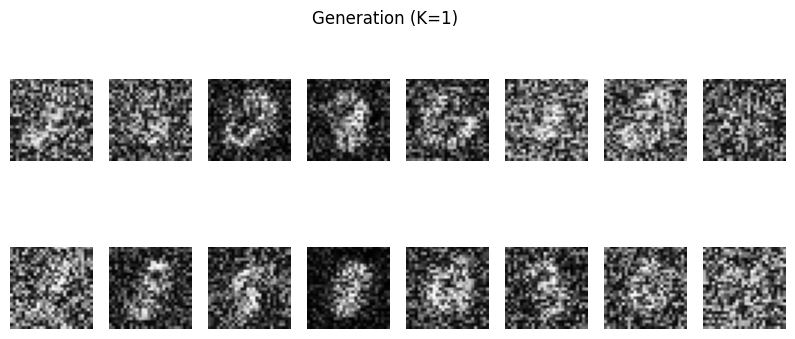

--- Epoch 1 finished, Average Loss: 738.3346 ---


KeyboardInterrupt: 

In [ ]:
#### --------------TRAINING-----------------------------

# Parameters
n_epochs = 100
learning_rate = 1e-3
n_epsilons_training = 1
lambda_reg = 0.01

# Initialization
dynamics_net = DynamicsNet().to(device)
ffjord_model = FFJORD(dynamics_net, n_epsilons=n_epsilons_training, lambda_reg=lambda_reg).to(device)
optimizer = torch.optim.Adam(ffjord_model.parameters(), lr=learning_rate, weight_decay = 1e-5)

# Initialize scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

print("Beginning of training...")
start_time = time.time()
for epoch in tqdm.tqdm(range(n_epochs+1)):
    total_loss = 0.0
    ffjord_model.train()

    for i, (x_batch, _) in enumerate(train_loader):

        x_batch = x_batch.to(device)
        optimizer.zero_grad()

        # ffjord_model returns log-probability and regularization term
        log_prob, reg_loss_term = ffjord_model(x_batch)

        # Negative Log-Likelihood (NLL) Loss
        nll_loss = -torch.mean(log_prob)

        # Total Loss = NLL Loss + Kinetic Regularization Loss
        loss = nll_loss + torch.mean(reg_loss_term)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(ffjord_model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_train_loss = total_loss / len(train_loader)
    scheduler.step(avg_train_loss)
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Generation
    ffjord_model.eval()
    with torch.no_grad():
        generated_images = ffjord_model.generate(n_samples=16)
    # Display
    if generated_images is not None:
        # Example of generation after training
        plot_generations(generated_images, title=f"Generation (K={n_epsilons_training})")


    print(f'--- Epoch {epoch+1} finished, Average Loss: {total_loss / len(train_loader):.4f} ---')
end_time = time.time()-start_time
print("Training finished. process time: {}sec".format(end_time))